# Gaussian Hidden Markov Models

In [1]:
# Set your working directory
import sys
sys.path.insert(0, "../models/")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from HMM import HMM
from posteriors import wishart,norm, dirichlet, simul_s, _Phi,order
from simulation import simul_gauss

# We will fit a two component gaussian HMM

A k components gaussian HMM is made of :
* A posterior `normal-inverse_wishart` distribution over $\theta = (\mu,\Sigma) \in IR^{kxd}xIR^{kxdxd}$; where $d$ = dim of the gaussian vectors
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{kxk}$

We start by defining the posterior of $\theta = \left(\mu,\Sigma\right)$

In [4]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \Omega^{-1} is simulated instead of \Omega

#Let set the default hyperparameters

d = 2 # dim of our gaussian vectors

nu = np.array([20, 20]) # Degree of freedoms of the prior of \Omega
omega_inv = 30*np.array([np.eye(d), np.eye(d)]) # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d), np.zeros(d)]) # Mean of the prior over  \mu
sigma = 30*np.array([np.eye(d), np.eye(d) ]) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)

Now, the **S** distribtuion ...

In [5]:
sDist = simul_s(func = _Phi) # S distribution, _Phi2 is the model evidence ie p(y), here the pdf of a normal dist

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set_default(a = np.array([[1, 1], [1,1]])) # Set default shape params

# The gaussian mixture on an artificial data

Let's simulate an artificial gaussian mixture

In [7]:
P0 = np.array([[0.33, 0.67], [0.85, 0.15]]) # the 'true' transition matrix
mu0 = np.array([-5*np.ones(d), 5*np.ones(d)])# The 'true' means
sigma0 = 10*np.array([np.eye(d), np.eye(d)]) # The true cov matrixes

In [8]:
y, S0 = simul_gauss(P0,mu0, sigma0, 500) # Simulate 500 sample of gaussian mixtures
y[:5] , S0[:5] 

(array([[  4.1692778 ,   6.32321038],
        [ -6.55594957,  -4.56157132],
        [  4.93451054,   8.17486301],
        [-12.11964469,  -7.30708159],
        [  6.93213525,   9.11455312]]), array([1, 0, 1, 0, 1]))

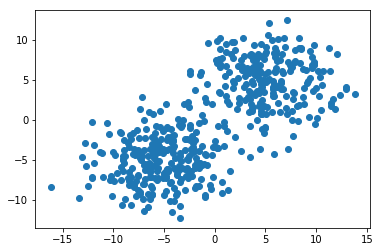

In [9]:
plt.scatter(y[:,0], y[:, 1])  # Our clusters

Now, we're gonna define the gHMM

In [10]:
Y = y # Obs
S = np.random.choice(2, len(Y)) # First sample of states for the gibbs sampler
P = np.array([[0.5,0.5],[0.5,0.5]]) # First sample of transition matrix
mu =  np.array([ np.zeros(d), np.zeros(d) ]) # First sample of mu
omega_inv =  np.array([np.eye(d),np.eye(d)])/30 # First sample of inv-cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Set first samples

In [11]:
ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [12]:
np.random.seed(111)
ghmm.run(3000) # Start the gibbs sampler n-times

Time : 2019-01-30  23:26:41   Elapsed : 0.00 min.  N_iter : 0000   Remain : 3000   %Remain : 100%
Time : 2019-01-30  23:27:01   Elapsed : 0.35 min.  N_iter : 0500   Remain : 2500   %Remain : 83%
Time : 2019-01-30  23:27:32   Elapsed : 0.86 min.  N_iter : 1000   Remain : 2000   %Remain : 66%
Time : 2019-01-30  23:27:56   Elapsed : 1.27 min.  N_iter : 1500   Remain : 1500   %Remain : 50%
Time : 2019-01-30  23:28:24   Elapsed : 1.73 min.  N_iter : 2000   Remain : 1000   %Remain : 33%
Time : 2019-01-30  23:28:53   Elapsed : 2.20 min.  N_iter : 2500   Remain : 0500   %Remain : 16%


## Checking for auto-correlation in the chain

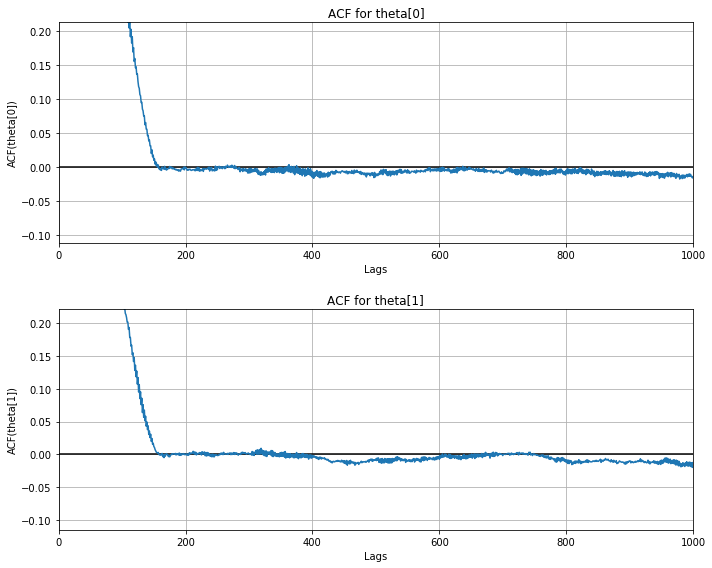

In [13]:
from utils import plot_ACF

mus = np.array([x["mu"].flatten() for x in ghmm.H["Theta"]]) # Only plotting for mu

plot_ACF(mus[:, :2], nlags = 1000)

The ACFs quickly converge to zero, the chain seems to be generated correctly

# Can we recover the true clusters ? Let's see !

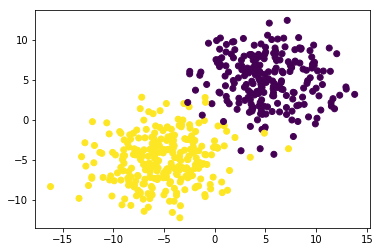

In [14]:
plt.scatter(Y[:,0], Y[:,1], c= ghmm.S)

In [15]:
(ghmm.sDist.rvs() == S0).mean() # Precision or Error rate

0.014

In [16]:
# Instead for taking just the last sample as prediction, we can compute the 
# mode of predicted states for each data point
Sgmm = np.array(ghmm.H["S"][-500:]) # We just consider latest steps in our simulation
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = 2 )
Sgmm = Sgmm.argmax(0)
Sgmm[:10]

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1], dtype=int64)

In [17]:
(Sgmm == S0 ).mean() # Mean Precision or Error rate

0.012

In [18]:
ghmm.tDictDist["mu"].rvs() # We can sample mu & omega distribution

array([[ 5.21424873,  4.92431566],
       [-4.80765887, -4.753132  ]])

In [19]:
np.linalg.inv(ghmm.tDictDist["omega_inv"].rvs()).round(2) # Sample of estimated cov (omega)

array([[[ 8.97, -0.77],
        [-0.77, 10.83]],

       [[10.38,  1.65],
        [ 1.65, 10.36]]])

In [20]:
np.array([history["mu"] for history in ghmm.H["Theta"][-1000::]]).mean(0) # Mean predicted value for mu

array([[ 5.18463608,  4.97433762],
       [-5.18721643, -5.014111  ]])

In [21]:
np.array(ghmm.H["P"][-1000::]).mean(0) # Mean transition matrix

array([[0.20578596, 0.79421404],
       [0.6870897 , 0.3129103 ]])

###  Comparison with Kmeans

In [22]:
from sklearn.cluster import KMeans

In [23]:
km = KMeans(n_clusters= 2)

In [24]:
km.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
(km.labels_ == S0).mean() # Error or precision rate

0.982

# Comparison with simple gaussian mixtures

In [26]:
from sklearn.mixture import GaussianMixture

In [27]:
gm = GaussianMixture(n_components= 2, covariance_type= "diag", max_iter= 100)
gm.fit(y)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [28]:
(gm.predict(y) == S0).mean() # Error or precision rate

0.016